# Calculating $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ for DESIJ1205+4110

**Author(s)**: Zareef Jafar, Muhammad Jobair Hasan, Anowar Shajib

## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yaml
from astropy.io import fits
from astropy.stats import SigmaClip
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import (
    SourceCatalog,
    SourceFinder,
    deblend_sources,
    detect_sources,
)

## Load Data

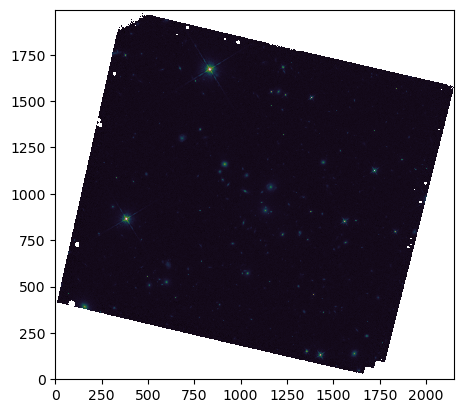

In [2]:
data, header = fits.getdata("DESIJ1554+0443_F140W_drz_sci.fits", header=True)
plt.imshow(np.log10(data), origin="lower", cmap="cubehelix", interpolation="nearest")

## Background estimation

/tmp/ipykernel_24286/3998831433.py:12: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


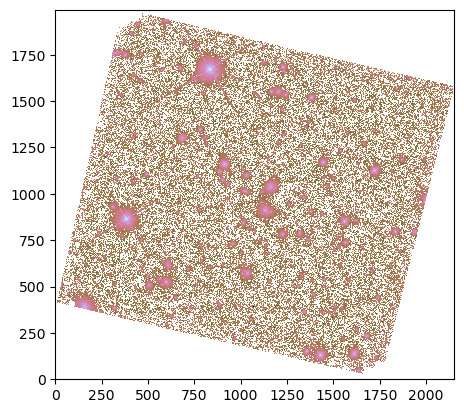

In [3]:
sigma_clip = SigmaClip(sigma=3.0)
bkg_estimator = MedianBackground()
bkg = Background2D(
    data,
    (50, 50),
    filter_size=(3, 3),
    sigma_clip=sigma_clip,
    bkg_estimator=bkg_estimator,
)

plt.imshow(
    np.log10(data - bkg.background),
    origin="lower",
    cmap="cubehelix",
    interpolation="nearest",
)

## Aperture Photometry and Plotting

In [4]:
# Background subtraction
bkg_subtracted_data = data - bkg.background
# Source detection and segmentation
threshold = 3 * bkg.background_rms
segment_map = detect_sources(bkg_subtracted_data, threshold, npixels=10)
segm_deblend = deblend_sources(
    bkg_subtracted_data,
    segment_map,
    npixels=10,
    nlevels=32,
    contrast=0.001,
    progress_bar=False,
)
# Source catalog creation
finder = SourceFinder(npixels=10, progress_bar=False)
segment_map = finder(bkg_subtracted_data, threshold)

cat = SourceCatalog(bkg_subtracted_data, segm_deblend)
print("SEGMENT MAP:\n", segment_map, "\n\nCAT:\n", cat)

SEGMENT MAP:
 <photutils.segmentation.core.SegmentationImage>
shape: (1994, 2152)
nlabels: 862
labels: [  1   2   3   4   5 ... 858 859 860 861 862] 

CAT:
 <photutils.segmentation.catalog.SourceCatalog>
Length: 862
labels: [  1   2   3   4   5 ... 858 859 860 861 862]


## Adjust the region surrounding your lensing system

In [27]:
# Set axis limits
set_x_lim1, set_x_lim2 = 997 - 150, 997 + 500
set_y_lim1, set_y_lim2 = 1076 - 310, 1076 + 250

/tmp/ipykernel_24286/3636062044.py:6: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2


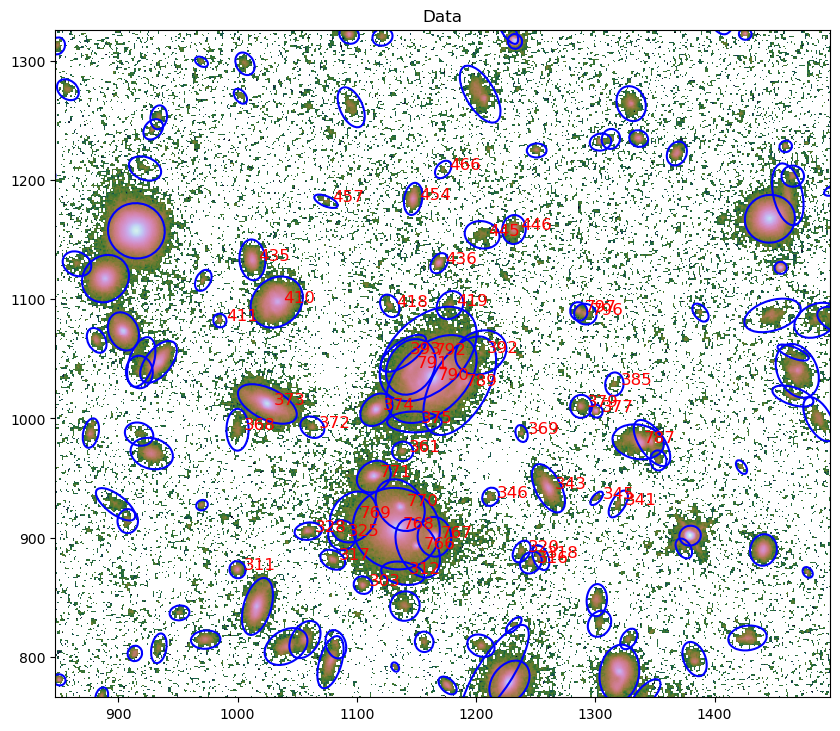

In [29]:
# Plotting
norm = simple_norm(data, "sqrt")

fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
ax1.imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
ax1.set_title("Data")

cat.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
# Before determining the central ID
# for i in range(len(cat)):
#     ax1.text(
#         cat.xcentroid[i] + 5,
#         cat.ycentroid[i],
#         f"{i}",
#         c="r",
#         fontsize=12
#     )

# After determining the central ID
id_central = 790
for i in range(len(cat)):
    if np.abs(cat.xcentroid[i] - cat.xcentroid[id_central]) < 180 and np.abs(cat.ycentroid[i] - cat.ycentroid[id_central]) < 180:
      ax1.text(
          cat.xcentroid[i] + 5,
          cat.ycentroid[i],
          f"{i}",
          c="r",
          fontsize=12
      )


ax1.set_xlim(set_x_lim1, set_x_lim2)
ax1.set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
ax1.set_clip_on(True)
ax1.set_clip_box(ax1.bbox)

In [53]:
# Defining a function for labeling only selected objects


def label_selected_objects(selected_ids):
    # Background subtraction
    data - bkg.background

    # Plotting
    simple_norm(data, "sqrt")
    fig, ax1 = plt.subplots(1, 1, figsize=(10, 12.5))
    
    ax1.imshow(
        np.log10(data - bkg.background),
        origin="lower",
        cmap="cubehelix",
        vmin=-4,
        vmax=2,
    )
    ax1.set_title("Selected object(s)")

    # Plot Kron apertures and label selected objects
    for obj_id in selected_ids:
        labels = [obj_id + 1]
        cat_subset = cat.get_labels(labels)
        cat_subset.plot_kron_apertures(ax=ax1, color="blue", lw=1.5)
        if np.abs(cat.xcentroid[obj_id] - cat.xcentroid[id_central]) < 180 and np.abs(cat.ycentroid[obj_id] - cat.ycentroid[id_central]) < 180:
            ax1.text(
                cat.xcentroid[obj_id] + 5,
                cat.ycentroid[obj_id],
                f"{obj_id}",
                c="r",
                fontsize=12
                # transform=ax1.transAxes
            )

    # Set axis limits
    ax1.set_xlim(set_x_lim1, set_x_lim2)
    ax1.set_ylim(set_y_lim1, set_y_lim2)

    # Hide text outside of the axes
    ax1.set_clip_on(True)
    ax1.set_clip_box(ax1.bbox)

    # Show the plot
    plt.show()


## The central deflector

/tmp/ipykernel_24286/3073230756.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


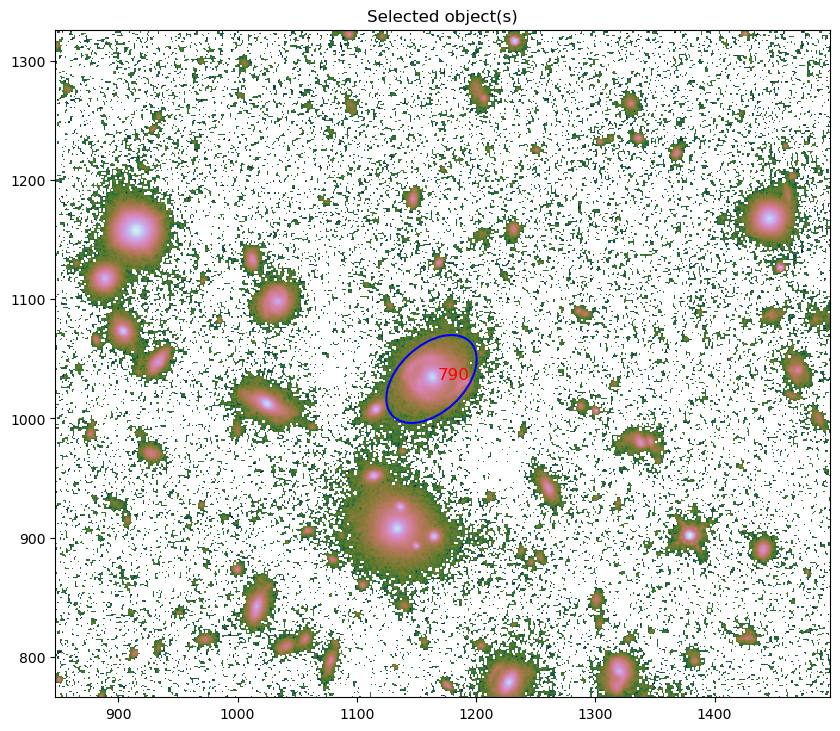

In [54]:
# object id of your central deflector/lens
id_central = [790]

label_selected_objects(id_central)

In [55]:
tbl = cat.to_table()
tbl["xcentroid"].info.format = ".2f"  # optional format
tbl["ycentroid"].info.format = ".2f"
tbl["kron_flux"].info.format = ".2f"

## Creating Lists of neighbouring Galaxies

Number of All Close galaxies within 30 arcseconds radius: 154


/tmp/ipykernel_24286/3073230756.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


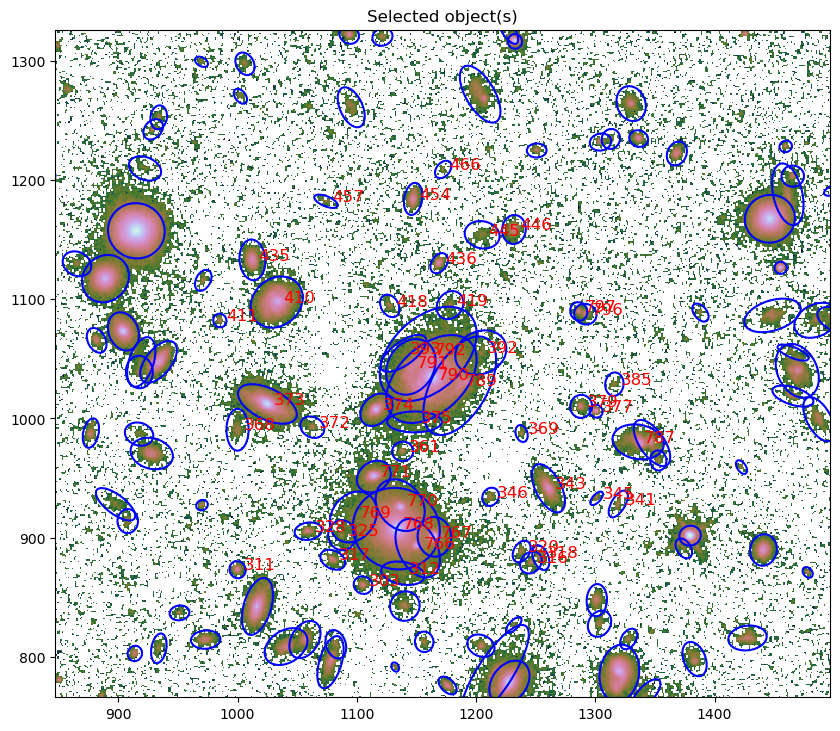

In [56]:
# All close galaxies

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_all = []
dist_galaxies_all = []
flux_galaxies_all = []
axis_ratios_all = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08:  # radius: 30 arcseconds
        close_galaxies_all.append(i)
        flux_galaxies_all.append(f)
        dist_galaxies_all.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_all.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of All Close galaxies within 30 arcseconds radius:", len(close_galaxies_all)
)
label_selected_objects(close_galaxies_all)

Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius:  72


/tmp/ipykernel_24286/3073230756.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


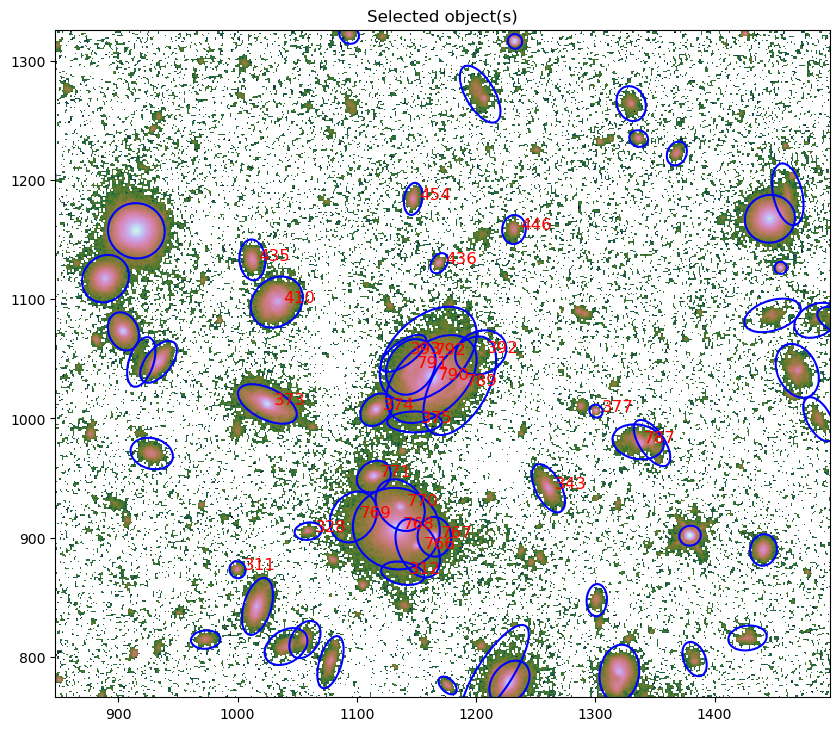

In [57]:
# close galaxies excluding sources lower than 1% of the central deflector

x0 = tbl["xcentroid"].value[id_central]
y0 = tbl["ycentroid"].value[id_central]
f0 = tbl["kron_flux"].value[id_central]

close_galaxies_1 = []
dist_galaxies_1 = []
flux_galaxies_1 = []
axis_ratios_1 = []

for i in range(len(tbl)):
    if i == segment_map.nlabels:
        continue
    x = tbl["xcentroid"].value[i]
    y = tbl["ycentroid"].value[i]
    f = tbl["kron_flux"].value[i]
    if (np.sqrt((x - x0) ** 2 + (y - y0) ** 2) < 30 / 0.08) & (
        f > f0 * 0.01
    ):  # radius: 30 arcseconds
        close_galaxies_1.append(i)
        flux_galaxies_1.append(f)
        dist_galaxies_1.append(np.sqrt((x - x0) ** 2 + (y - y0) ** 2))
        axis_ratios_1.append(np.sqrt(1 - tbl[i]["eccentricity"].value ** 2))
print(
    "Number of Close galaxies (excluding the dim sources) within 30 arcseconds radius: ",
    len(close_galaxies_1),
)
label_selected_objects(close_galaxies_1)

In [58]:
def distance_arcsec(pixel_distance):
    """
    Convert distance from unit of pixels into arcsec unit.

    :param pixel_distance: distance in unit of pixels
    :return: distance in arcsec unit
    """
    wcs = WCS(header)

    # Get the pixel scale in degrees per pixel
    pix_scale_deg = abs(wcs.wcs.cd[0, 0])

    # Convert pixel scale to arcseconds
    pix_scale_arcsec = pix_scale_deg * 3600

    dist_arcsec = pixel_distance * pix_scale_arcsec

    return dist_arcsec

## Identify the unwanted objects

/tmp/ipykernel_24286/3073230756.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


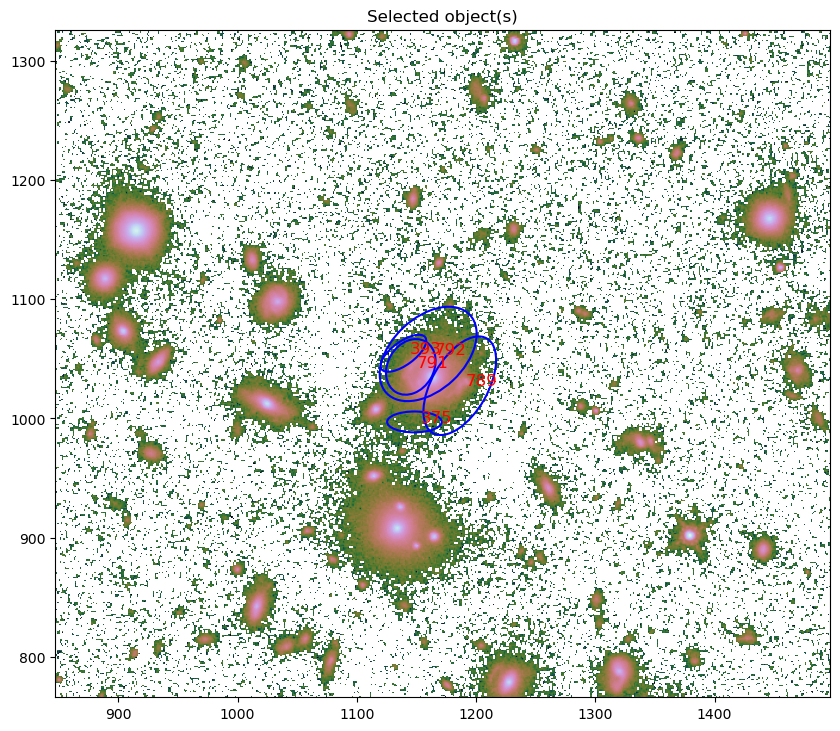

In [59]:
 # parts of the central deflector and lensed arc
id_central_2drop = [393, 792, 791, 789, 375] 
label_selected_objects(id_central_2drop)

/tmp/ipykernel_24286/3073230756.py:13: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background),


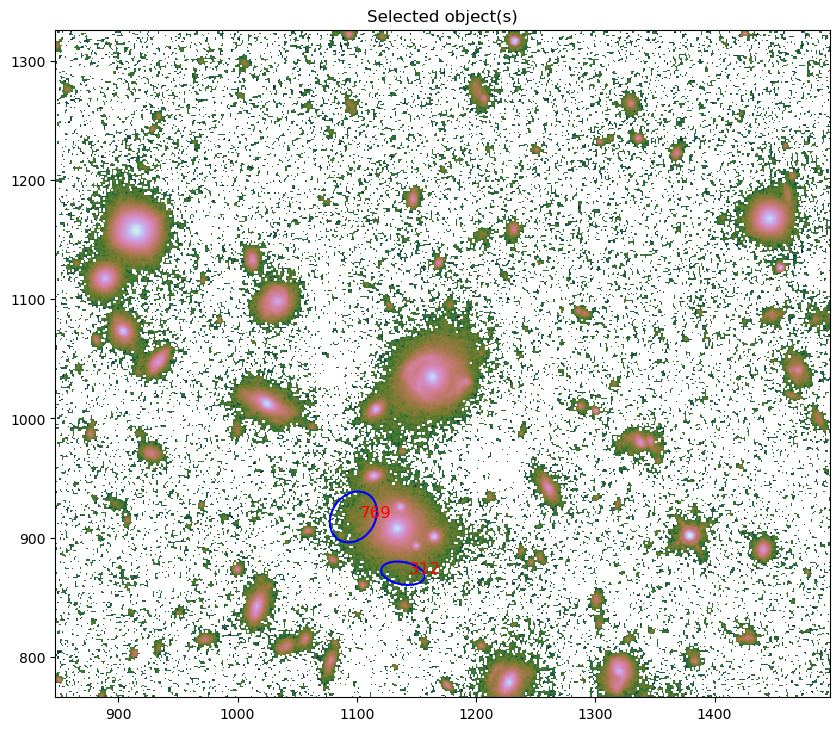

In [60]:
 # stars and other
id_others_2drop = [769,312] 
label_selected_objects(id_others_2drop)

### 20 Neighbouring Galaxies excluding central deflector, lensed arc , stars and other

In [61]:
df_all = pd.DataFrame({"Distance(pixels)": dist_galaxies_all})

df_all.set_index(pd.Index(close_galaxies_all), inplace=True)

df_all["Distance(arcsec)"] = distance_arcsec(df_all["Distance(pixels)"])
df_all["Flux"] = flux_galaxies_all
df_all["Axis Ratio"] = axis_ratios_all

# drop the central and other unwanted ids
df_all = df_all.drop(index=id_central_2drop)
# df_all = df_all.drop(index=id_others_2drop)

# Sort the DataFrame based on 'Distance'
df_all_sorted = df_all.sort_values(by="Distance(pixels)")
df_all_sys_removed = df_all_sorted

# first 20 galaxies
df_all_20 = df_all_sys_removed.iloc[:20]

print(df_all_20)

         Distance(pixels)      Distance(arcsec)         Flux  Axis Ratio
790                 [0.0]                 [0.0]  1044.573614    0.619475
392     [46.983568214218]  [3.7586854571374024]    19.529699    0.803669
374   [52.92940351100451]  [4.2343522808803185]   106.767505    0.731401
419  [63.867672766828996]   [5.109413821346268]     6.434641    0.825256
361   [65.36513835478954]    [5.22921106838311]     5.138200    0.920563
418   [70.59447746703252]   [5.647558197362545]     4.021506    0.720744
369   [88.33987178784285]   [7.067189743027357]     2.059620    0.673577
771   [95.04068152417055]   [7.603254521933568]   108.461691    0.799265
436    [97.3624244820051]   [7.788993958560329]    15.236387    0.688385
372  [107.81430697833652]   [8.625144558266834]     5.362714    0.804520
770  [109.02485468391168]   [8.721988374712847]   139.946412    0.770816
346  [110.53851760936143]   [8.843081408748827]     3.511109    0.850340
379  [127.57581912515205]  [10.206065530012062]    

### 20 Neighbouring Galaxies excluding central deflector, lensed arc , stars and other + dim sources

In [62]:
df_1 = pd.DataFrame({"Distance(pixels)": dist_galaxies_1})

df_1.set_index(pd.Index(close_galaxies_1), inplace=True)

df_1["Distance(arcsec)"] = distance_arcsec(df_1["Distance(pixels)"])
df_1["Flux"] = flux_galaxies_1
df_1["Axis Ratio"] = axis_ratios_1


# Exclude the lensing system and other undesirable members
df_1_sys_removed = df_1.drop(
    index=id_central_2drop 
)

df_1_sys_and_othes_removed = df_1_sys_removed.drop(
    index=id_others_2drop 
)
 

# Sort the DataFrame based on 'Distance'
df_1_sorted = df_1_sys_and_othes_removed.sort_values(by="Distance(pixels)")

# first 20 galaxies
df_1_20 = df_1_sorted.iloc[:20]

print(df_1_20)

         Distance(pixels)      Distance(arcsec)         Flux  Axis Ratio
790                 [0.0]                 [0.0]  1044.573614    0.619475
392     [46.983568214218]  [3.7586854571374024]    19.529699    0.803669
374   [52.92940351100451]  [4.2343522808803185]   106.767505    0.731401
771   [95.04068152417055]   [7.603254521933568]   108.461691    0.799265
436    [97.3624244820051]   [7.788993958560329]    15.236387    0.688385
770  [109.02485468391168]   [8.721988374712847]   139.946412    0.770816
768  [128.90835286239732]  [10.312668228991683]  1049.058422    0.924462
767    [132.361832173356]  [10.588946573868373]   133.264701    0.845918
343  [134.23456604522548]   [10.73876528361793]    64.541193    0.482311
373   [139.2137526986358]  [11.137100215890753]   415.886073    0.487092
377  [140.62268534634183]  [11.249814827707233]    11.876507    0.920711
766  [142.39834501960485]  [11.391867601568274]    77.675807    0.614627
446  [143.18998243035045]  [11.455198594427921]    

## Determining $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ and the corresponding radii

/tmp/ipykernel_24286/3053078570.py:17: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_24286/3053078570.py:20: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_24286/3053078570.py:23: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
/tmp/ipykernel_24286/3053078570.py:26: RuntimeWarning: invalid value encountered in log10
  np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2



EXCLUDING DIM SOURCES
R 10: [11.13710022]
R 20: [18.25178838]
Sigma 10: [0.02566291]
Sigma 20: [0.01911038]

FOR All SOURCES
R 10: [8.62514456]
R 20: [11.13710022]
Sigma 10: [0.04278754]
Sigma 20: [0.05132582]


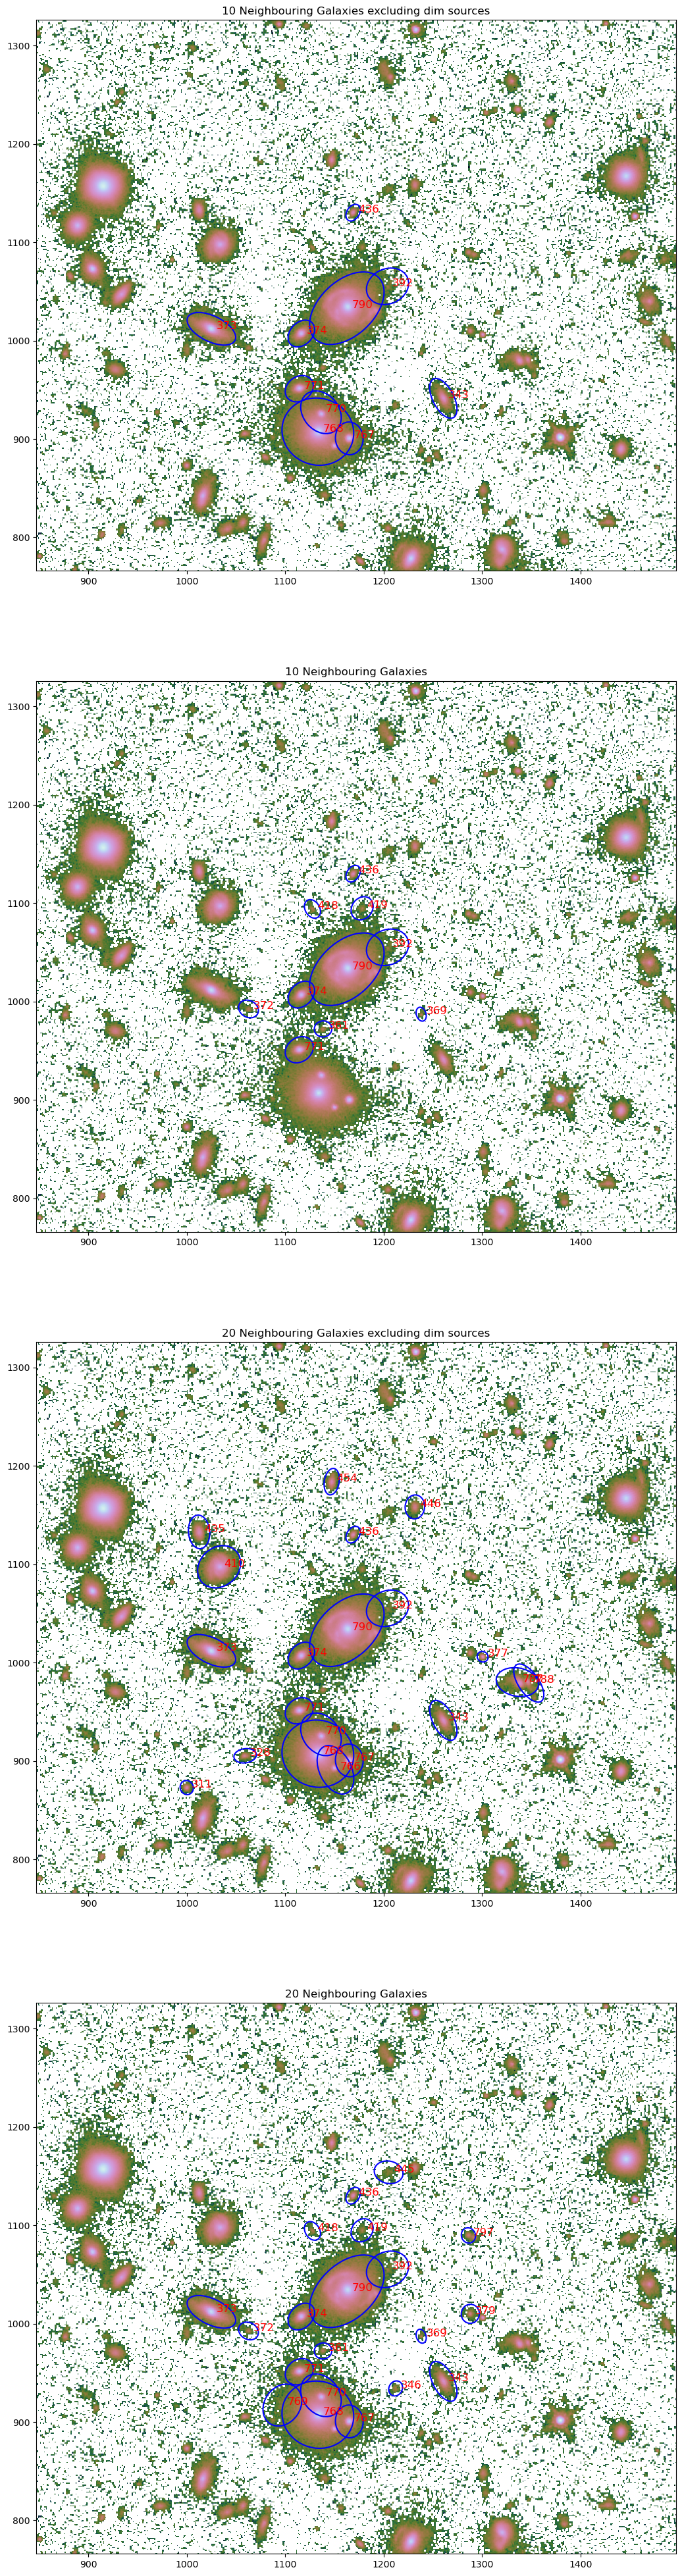

In [63]:
close_ids_all = list(df_all_20.index.values)
close_ids_all_10 = close_ids_all[:10]

updated_close_ids_all = [s + 1 for s in close_ids_all]
updated_close_ids_all_10 = updated_close_ids_all[:10]

close_ids_1 = list(df_1_20.index.values)
close_ids_1_10 = close_ids_1[:10]

updated_close_ids_1 = [s + 1 for s in close_ids_1]
updated_close_ids_1_10 = updated_close_ids_1[:10]

norm = simple_norm(data, "sqrt")
fig, axs = plt.subplots(4, 1, figsize=(25, 50))  # , figsize=(10, 12.5)

axs[0].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[1].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[2].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)
axs[3].imshow(
    np.log10(data - bkg.background), origin="lower", cmap="cubehelix", vmin=-4, vmax=2
)

cat_subset_1_10 = cat.get_labels(updated_close_ids_1_10)
cat_subset_1_10.plot_kron_apertures(ax=axs[0], color="blue", lw=1.5)

cat_subset_all_10 = cat.get_labels(updated_close_ids_all_10)
cat_subset_all_10.plot_kron_apertures(ax=axs[1], color="blue", lw=1.5)

cat_subset_all = cat.get_labels(updated_close_ids_1)
cat_subset_all.plot_kron_apertures(ax=axs[2], color="blue", lw=1.5)

cat_subset_1 = cat.get_labels(updated_close_ids_all)
cat_subset_1.plot_kron_apertures(ax=axs[3], color="blue", lw=1.5)

axs[0].set_title("10 Neighbouring Galaxies excluding dim sources")
axs[1].set_title("10 Neighbouring Galaxies")
axs[2].set_title("20 Neighbouring Galaxies excluding dim sources")
axs[3].set_title("20 Neighbouring Galaxies")

for i in close_ids_1_10:
    axs[0].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all_10:
    axs[1].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_1:
    axs[2].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

for i in close_ids_all:
    axs[3].text(cat.xcentroid[i] + 5, cat.ycentroid[i], f"{i}", c="r", fontsize=12)

axs[0].set_xlim(set_x_lim1, set_x_lim2)
axs[0].set_ylim(set_y_lim1, set_y_lim2)

axs[1].set_xlim(set_x_lim1, set_x_lim2)
axs[1].set_ylim(set_y_lim1, set_y_lim2)

axs[2].set_xlim(set_x_lim1, set_x_lim2)
axs[2].set_ylim(set_y_lim1, set_y_lim2)

axs[3].set_xlim(set_x_lim1, set_x_lim2)
axs[3].set_ylim(set_y_lim1, set_y_lim2)

# hide all text outside of the axes
axs[0].set_clip_on(True)
axs[0].set_clip_box(axs[0].bbox)

axs[1].set_clip_on(True)
axs[1].set_clip_box(axs[0].bbox)

axs[2].set_clip_on(True)
axs[2].set_clip_box(axs[0].bbox)

axs[3].set_clip_on(True)
axs[3].set_clip_box(axs[0].bbox)

R_10_1 = df_1_20.iloc[9, df_1_20.columns.get_loc("Distance(arcsec)")]
R_20_1 = df_1_20.iloc[19, df_1_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_1 = 10 / (np.pi * R_10_1**2)
Sigma_20_1 = 20 / (np.pi * R_20_1**2)

R_10_all = df_all_20.iloc[9, df_all_20.columns.get_loc("Distance(arcsec)")]
R_20_all = df_all_20.iloc[19, df_all_20.columns.get_loc("Distance(arcsec)")]
Sigma_10_all = 10 / (np.pi * R_10_all**2)
Sigma_20_all = 20 / (np.pi * R_20_all**2)

print("")
print("EXCLUDING DIM SOURCES")
print("R 10:", R_10_1)
print("R 20:", R_20_1)
print("Sigma 10:", Sigma_10_1)
print("Sigma 20:", Sigma_20_1)

print("")
print("FOR All SOURCES")
print("R 10:", R_10_all)
print("R 20:", R_20_all)
print("Sigma 10:", Sigma_10_all)
print("Sigma 20:", Sigma_20_all)

## Store the $\Sigma_{10}$, $\Sigma_{10, \rm flux\ selected}$, $\Sigma_{20}$, $\Sigma_{20, \rm flux\ selected}$ values in the YAML file

In [65]:
# Existing YAML file with other parameters
existing_yaml_file = "DESIJ1554+0443_point_estimates.yml"

# Variables to include in the YAML file
environment_variables = {
    "Sigma_10_flux_selected": Sigma_10_1,
    "Sigma_20_flux_selected": Sigma_20_1,
    "Sigma_10": Sigma_10_all,
    "Sigma_20": Sigma_20_all,
}

# make all the numpy variales to float
environment_variables = {
    key: [float(item) for item in value] if isinstance(value, list) else float(value)
    for key, value in environment_variables.items()
}

# Load existing YAML content if the file exists
existing_content = {}
try:
    with open(existing_yaml_file, "r") as file:
        existing_content = yaml.safe_load(file)
except FileNotFoundError:
    pass

# Update the existing content with new variables
existing_content.update(environment_variables)

# Write the updated content back to the YAML file
with open(existing_yaml_file, "w") as file:
    yaml.dump(existing_content, file, default_flow_style=False)

In [66]:
# Read the YAML file using safe_load

with open(existing_yaml_file, "r") as file:
    try:
        yaml_read = yaml.safe_load(file)
        print("YAML Data:")
        print("Number of params:", len(list(yaml_read.keys())))
        print(yaml_read)
    except yaml.YAMLError as e:
        print(f"Error reading YAML file: {e}")

YAML Data:
Number of params: 17
{'R_eff_light': 0.7774285505755497, 'Sigma_10': 0.0427875443261192, 'Sigma_10_flux_selected': 0.02566290829653011, 'Sigma_20': 0.05132581659306022, 'Sigma_20_flux_selected': 0.019110377836620118, 'center_x_light': [-0.32682929460540777, 0.0005949301421480091, 0.0006465694674493982], 'center_x_mass': [-0.3042459461041694, 0.00405957906883031, 0.003990217241035876], 'center_y_light': [-0.10028703466436645, 0.0006680913105993752, 0.000714595096735049], 'center_y_mass': [-0.10400938124025653, 0.004253989121380974, 0.004895526079434984], 'gamma': [1.8464672956121766, 0.0214816753114353, 0.019335881814845912], 'gamma_shear': [0.10620526372656147, 0.005453581352756948, 0.005691498505949022], 'phi_light': [-0.8618252517799041, 0.014462292122946807, 0.012404586107597204], 'phi_mass': [-0.9651671975474136, 0.038456075826235, 0.040581961310125925], 'phi_shear': [0.11811282229489554, 0.0256792159940155, 0.022656775590620667], 'q_light': [0.9190871138802292, 0.001726